# Optimized F16 Flight Dynamics

In [1]:
# disable numba to compare with original VVAerobench
import yaml
import os
numba_config = ".numba_config.yaml"
if not os.path.exists(numba_config):
    pass
with open(".numba_config.yaml", "w") as fp:
    fp.write(yaml.dump({"DISABLE_JIT": True}))
    
import csaf_f16.ngoals as f16g
from csaf_f16.acas import AcasScenarioViewer

import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

In [2]:
import csaf_f16
from csaf_f16.messages import *
from csaf_f16.components import F16PlantComponent, F16LlcComponent
from csaf import ContinuousComponent

In [3]:
# import F16_CSAF's
from csaf_f16.systems import F16Simple

# import ours
# make sure this is installed!
from f16dynamics.csaf import F16FastPlantComponent, F16FastLlcComponent, F16FastSimple

## Simple Benchmark

Simple GCAS scenario with most time spent in the f16 plant dynamics model.

In [4]:
# timing context
from time import perf_counter
from contextlib import contextmanager

@contextmanager
def catchtime(task_name) -> float:
    start = perf_counter()
    yield lambda: perf_counter() - start
    # Note: print is included here to guarantee only time of code inside the CM CL.is measured
    print(f'[{task_name}] Time: {perf_counter() - start:.3f} seconds')

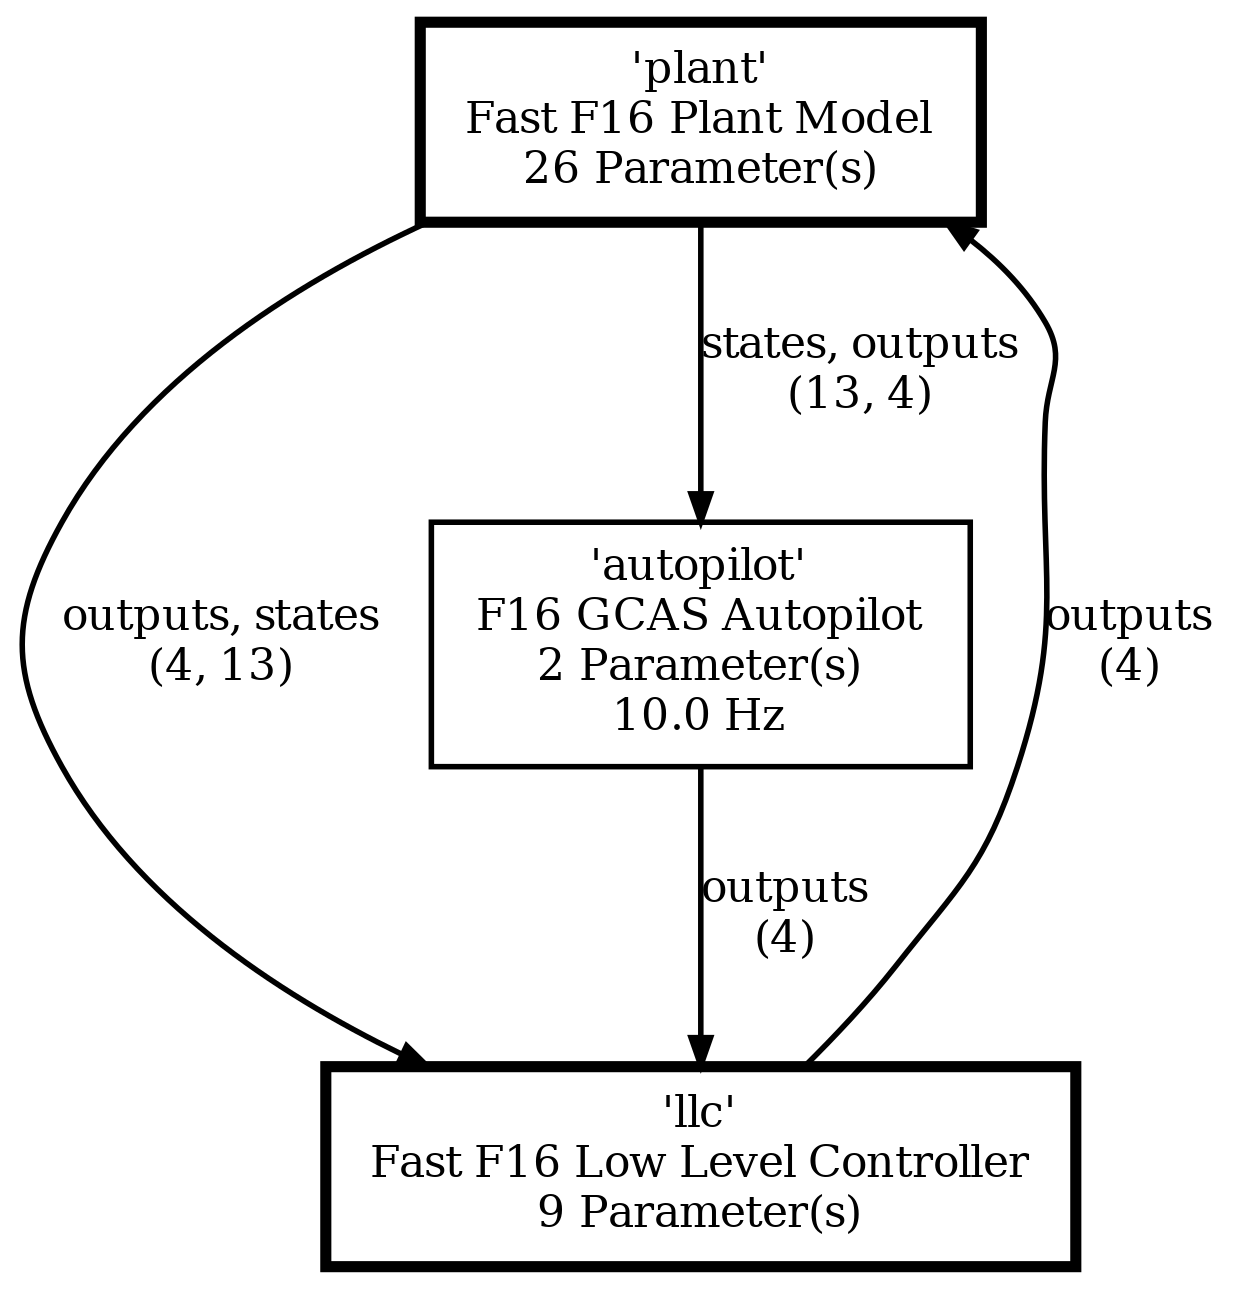

In [5]:
import csaf.utils as csafutils

sys = F16Simple()
sys_fast = F16FastSimple()


# view the system
csafutils.view_block_diagram(sys_fast, ipython_notebook=True)

In [6]:

with catchtime("F16Simple Baseline") as t:
    trajs = sys.simulate_tspan((0.0, 120.0))
with catchtime("F16Simple Fast") as t:
    trajs_fast = sys_fast.simulate_tspan((0.0, 120.0))

[F16Simple Baseline] Time: 4.952 seconds
[F16Simple Fast] Time: 0.425 seconds


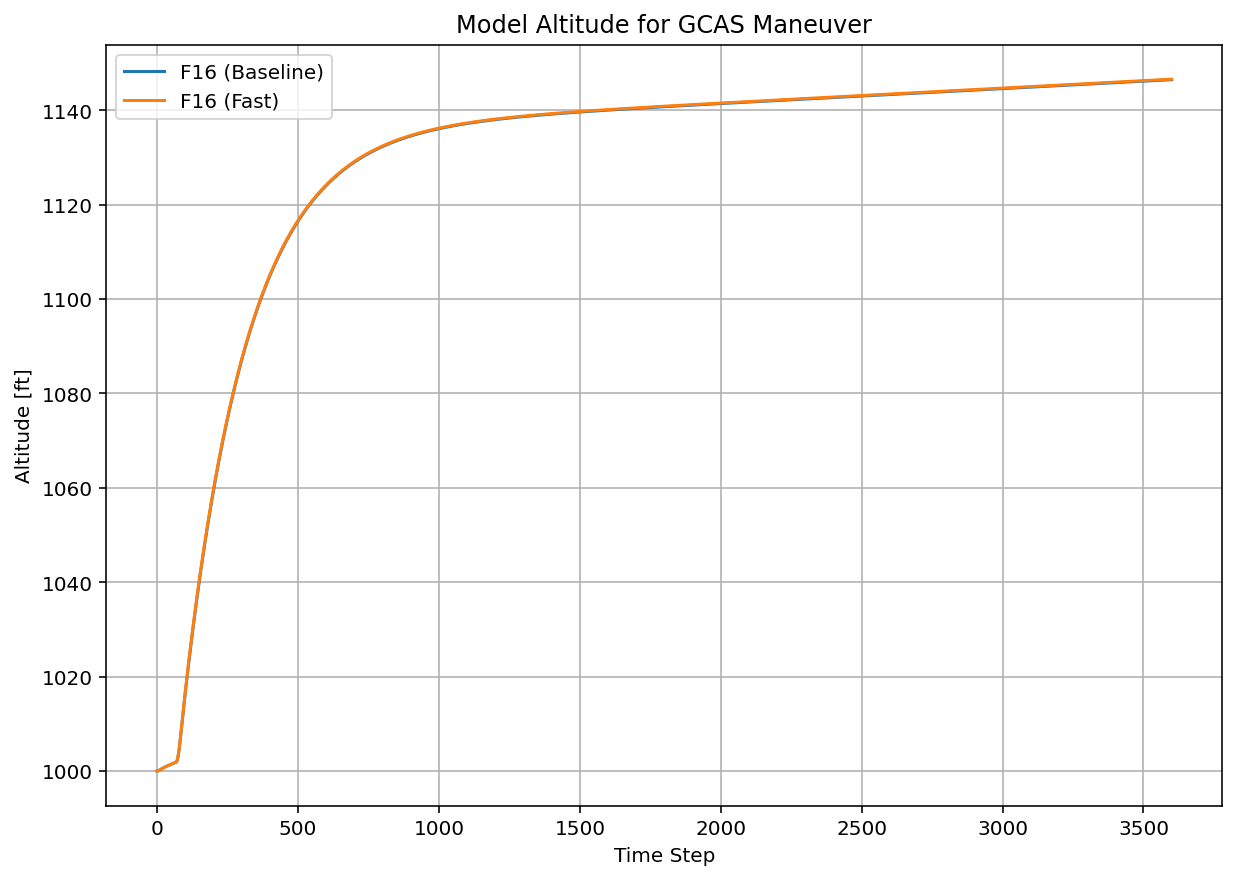

In [7]:
plt.figure(figsize=(10, 7))
plt.plot(np.array(trajs["plant"].states)[:, 11], label="F16 (Baseline)")
plt.plot(np.array(trajs_fast["plant"].states)[:, 11], label="F16 (Fast)")
plt.grid()
plt.title("Model Altitude for GCAS Maneuver")
plt.xlabel("Time Step")
plt.ylabel("Altitude [ft]")
plt.legend()
plt.show()

## ACAS Scenario

More time is spent outside of the plant dynamics model (expect less of a difference).

In [8]:
# baseline "normal" scenario
ar = f16g.AcasHeadOnScenario()
sys = ar.generate_system((15E3, 1000.0, 12000.0, 0.0, -3.141592))
trajs = sys.simulate_tspan((0.0, 10.0))
av = AcasScenarioViewer(trajs, ar)

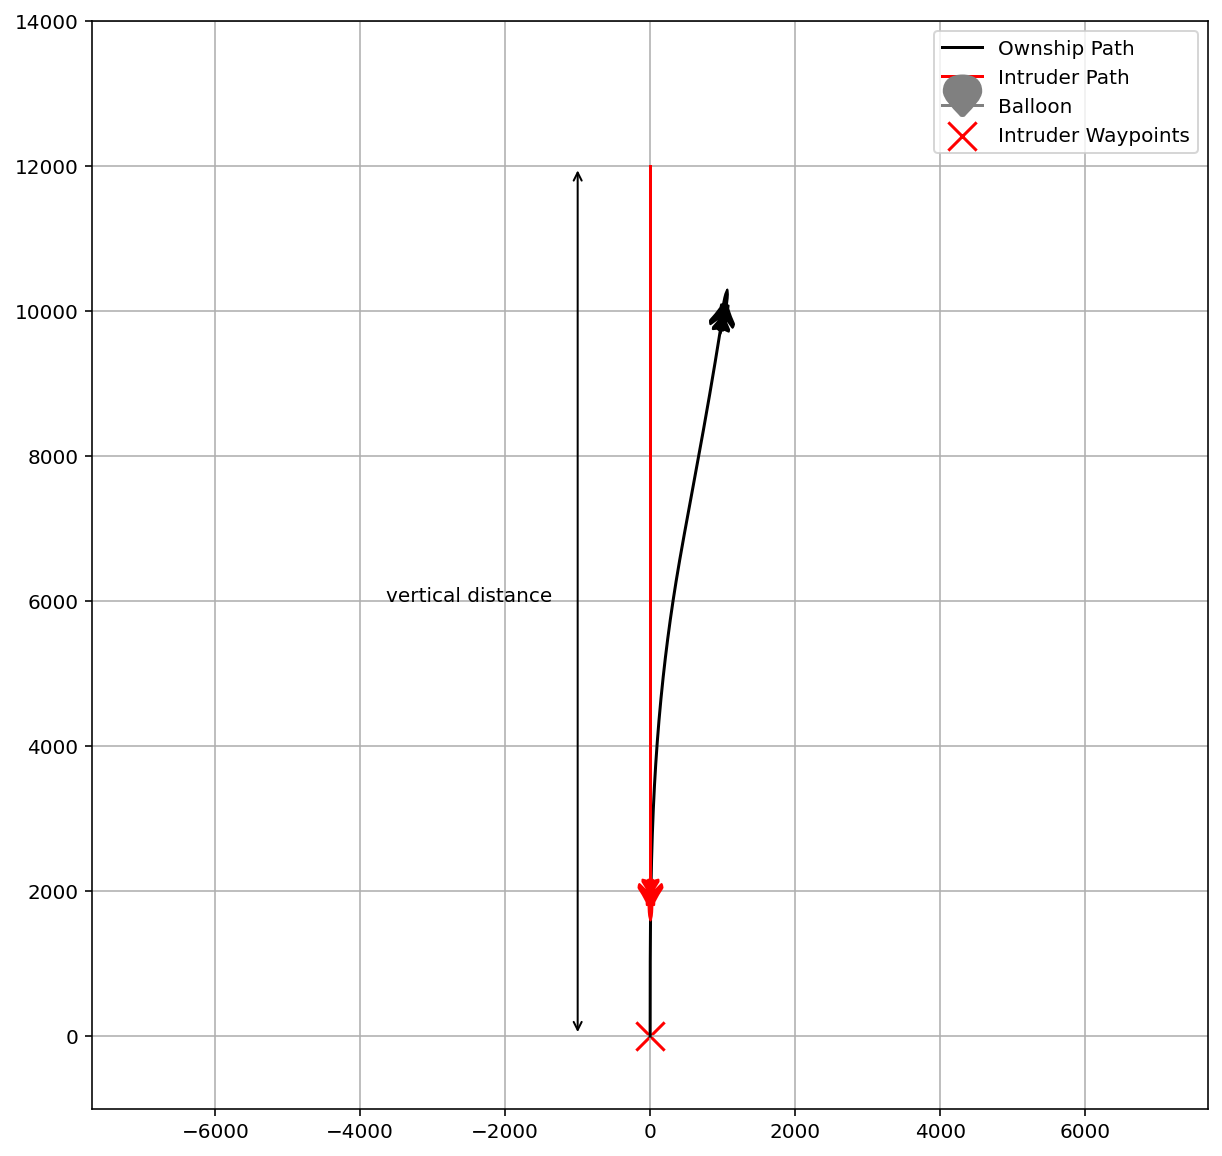

<Figure size 720x720 with 0 Axes>

In [9]:
f, ax = av.summary_plot(bounds = ((-3000, 3000), (-1000, 14000)))
ax.annotate(text='', xy=(-1000.0,0.0), xytext=(-1000.0,12000.0), arrowprops=dict(arrowstyle='<->'))
ax.annotate(text='vertical distance', xy=(-2500.0,6000.0), ha='center')
plt.show()

In [10]:
with catchtime("F16 ACAS Baseline") as t:
    trajs = sys.simulate_tspan((0.0, 120.0))
sys.component_instances["plant"] = F16FastPlantComponent()
sys.component_instances["llc"] = F16FastLlcComponent()
sys.component_instances["intruder_plant"] = F16FastPlantComponent()
sys.component_instances["intruder_llc"] = F16FastLlcComponent()
sys.components["plant"] = F16FastPlantComponent
sys.components["llc"] = F16FastLlcComponent
sys.components["intruder_plant"] = F16FastPlantComponent
sys.components["intruder_llc"] = F16FastLlcComponent
with catchtime("F16 ACAS Fast") as t_fast:
    trajs = sys.simulate_tspan((0.0, 120.0))

[F16 ACAS Baseline] Time: 10.702 seconds
[F16 ACAS Fast] Time: 1.070 seconds
